In [ ]:
import psutil
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from src.utils.utils import get_base_dir

In [2]:
base_dir = get_base_dir()
base_dir

WindowsPath('C:/Users/lauta/Desktop/Lautaro/maestria_ds/labo3/repo-entrega')

## 1. Carga de datos

In [3]:
# Cargar datos principales
DATA_PATH_SELL_IN = base_dir / "data/interim/sell_in_completo.feather"
sell_in = pd.read_feather(DATA_PATH_SELL_IN)

print(f"Dimensiones originales: {sell_in.shape}")
print(f"Período mínimo: {sell_in['periodo'].min()}")
print(f"Período máximo: {sell_in['periodo'].max()}")
print(f"Productos únicos: {sell_in['product_id'].nunique()}")
print(f"Clientes únicos: {sell_in['customer_id'].nunique()}")

Dimensiones originales: (19877532, 4)
Período mínimo: 201701
Período máximo: 201912
Productos únicos: 1233
Clientes únicos: 597


In [4]:
# Cargar datos a predecir
predict_file = base_dir / "data/predict/raw/product_id_apredecir201912.txt"
df_pred_orig = pd.read_csv(predict_file, sep="\t", encoding="utf-8")
print(f"Registros a predecir: {df_pred_orig.shape[0]}")
df_pred_orig.head()

Registros a predecir: 780


,product_id
0,20001
1,20002
2,20003
3,20004
4,20005


## 2. Preprocesamiento y agregación

In [5]:
# Agregar datos por período, producto y cliente
sell_in_agrup = sell_in.groupby(["periodo", "product_id", "customer_id"]).agg({"tn": "sum"}).reset_index()
del sell_in # limpiar memoria
sell_in_agrup = sell_in_agrup.sort_values(by=["product_id", "customer_id", "periodo"]).reset_index(drop=True)

print(f"Dimensiones después de agregación: {sell_in_agrup.shape}")
sell_in_agrup.head()

Dimensiones después de agregación: (19877532, 4)


,periodo,product_id,customer_id,tn
0,201701,20001,10001,99.43861
1,201702,20001,10001,198.84365
2,201703,20001,10001,92.46537
3,201704,20001,10001,13.29728
4,201705,20001,10001,101.00563


### Checks de la base

In [6]:
# Análisis de distribución de toneladas totales
print("Top 10 productos por volumen total:")
top_products = sell_in_agrup.groupby("product_id").agg({"tn": "sum"}).sort_values(by="tn", ascending=False).head(10)
print(top_products)

print("\nTop 10 clientes por volumen total:")
top_customers = sell_in_agrup.groupby("customer_id").agg({"tn": "sum"}).sort_values(by="tn", ascending=False).head(10)
print(top_customers)

Top 10 productos por volumen total:
                     tn
product_id             
20001       50340.39558
20002       36337.25439
20003       32004.15274
20004       24178.15379
20005       23191.21852
20007       22018.45234
20006       21088.76007
20008       19948.29352
20010       18671.07918
20012       17813.59935

Top 10 clientes por volumen total:
                       tn
customer_id              
10001        109203.60059
10002         77333.16887
10003         71375.91941
10004         63065.94269
10005         51467.04585
10006         49779.23364
10007         43740.39629
10008         41962.99046
10009         38742.71591
10011         34675.44337


### Graficamos caso aleatorio (cliente - producto)

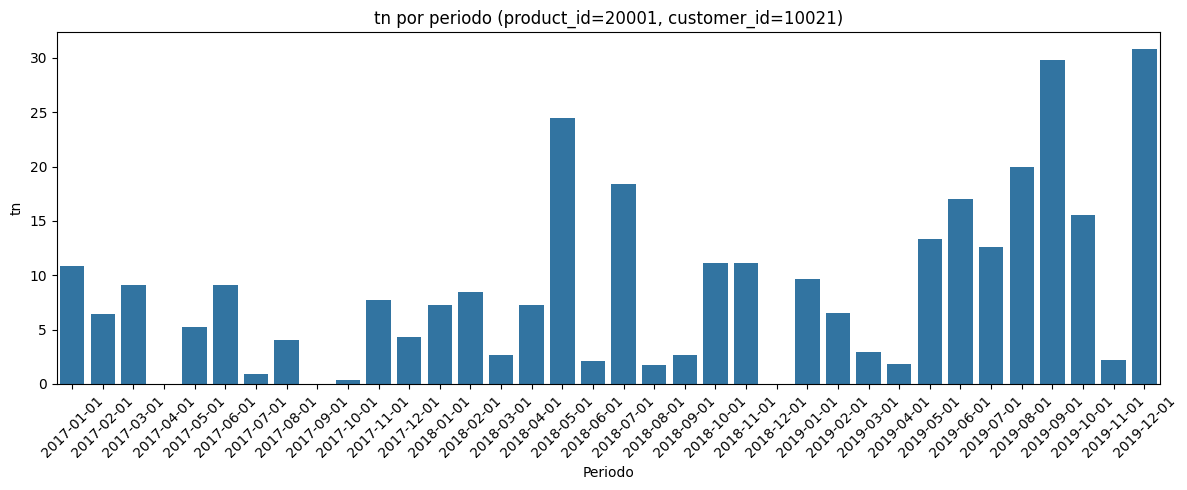

In [7]:
from matplotlib import pyplot as plt
import seaborn as sns
sell_in_agrup["fecha"] = pd.to_datetime(
    sell_in_agrup["periodo"].astype(str), format="%Y%m"
)

plt.figure(figsize=(12, 5))
# aleatorio
pid, cid = sell_in_agrup["product_id"].values[745], sell_in_agrup["customer_id"].values[745]
sns.barplot(
    data=sell_in_agrup[(sell_in_agrup["product_id"]==pid) & (sell_in_agrup["customer_id"]==cid)], 
    x="fecha", 
    y="tn"
)
plt.title(f"tn por periodo (product_id={pid}, customer_id={cid})")
plt.ylabel("tn")
plt.xlabel("Periodo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
sell_in_agrup[sell_in_agrup["product_id"]==pid].groupby(["periodo"])["tn"].sum().reset_index().sort_values(by="periodo", ascending=False).head(5)

,periodo,tn
35,201912,1504.68856
34,201911,1397.37231
33,201910,1561.50552
32,201909,1660.00561
31,201908,1261.34529


In [9]:
sell_in_agrup[sell_in_agrup["customer_id"]==cid].groupby(["periodo"])["tn"].sum().reset_index().sort_values(by="periodo", ascending=False).head(5)

,periodo,tn
35,201912,791.70208
34,201911,77.33122
33,201910,376.08038
32,201909,381.45007
31,201908,167.19448


In [10]:
sell_in_agrup[(sell_in_agrup["product_id"]==pid) & (sell_in_agrup["customer_id"]==cid)].groupby(["periodo"])["tn"].sum().reset_index().sort_values(by="periodo", ascending=False).head(5)

,periodo,tn
35,201912,30.80578
34,201911,2.21802
33,201910,15.52611
32,201909,29.81999
31,201908,19.96214


In [11]:
# Obtener todos los clientes únicos del dataset actual
clientes_unicos = sell_in_agrup['customer_id'].unique()

# Crear todas las combinaciones de product_id (de df_pred_orig) con customer_id
combinaciones = []
for product_id in df_pred_orig['product_id']:
    for customer_id in clientes_unicos:
        combinaciones.append({
            'periodo': 202002,
            'product_id': product_id,
            'customer_id': customer_id,
            'tn': np.nan  # Será el valor a predecir
        })
        combinaciones.append({
            'periodo': 202001,
            'product_id': product_id,
            'customer_id': customer_id,
            'tn': np.nan  # Queda nulo
        })

# Crear DataFrame con las nuevas filas
df_202001_202002 = pd.DataFrame(combinaciones)
df_202001_202002["fecha"] = pd.to_datetime(
    df_202001_202002["periodo"].astype(str), format="%Y%m"
)

print(f"Registros creados para 202001 y 202002: {df_202001_202002.shape[0]}")
print(f"Registros para 202001: {(df_202001_202002['periodo'] == 202001).sum()}")
print(f"Registros para 202002: {(df_202001_202002['periodo'] == 202002).sum()}")
print(f"Productos únicos: {df_202001_202002['product_id'].nunique()}")
print(f"Clientes únicos: {df_202001_202002['customer_id'].nunique()}")

Registros creados para 202001 y 202002: 931320
Registros para 202001: 465660
Registros para 202002: 465660
Productos únicos: 780
Clientes únicos: 597


In [12]:
df_202001_202002.head()

,periodo,product_id,customer_id,tn,fecha
0,202002,20001,10001,NaN,2020-02-01
1,202001,20001,10001,NaN,2020-01-01
2,202002,20001,10002,NaN,2020-02-01
3,202001,20001,10002,NaN,2020-01-01
4,202002,20001,10003,NaN,2020-02-01


In [13]:
sell_in_agrup.sort_values("periodo", ascending=False).head()

,periodo,product_id,customer_id,tn,fecha
14803375,201912,20880,10104,0.00000,2019-12-01
19877531,201912,21299,10637,0.00000,2019-12-01
35,201912,20001,10001,180.21938,2019-12-01
14803339,201912,20880,10103,0.00000,2019-12-01
18306414,201912,21176,10613,0.00000,2019-12-01


In [14]:
# Concatenar con el dataset original
sell_in_agrup_extended = pd.concat([sell_in_agrup, df_202001_202002], ignore_index=True)
sell_in_agrup_extended = sell_in_agrup_extended.sort_values(by=["product_id", "customer_id", "periodo"]).reset_index(drop=True)
del sell_in_agrup

print(f"Dimensiones finales: {sell_in_agrup_extended.shape}")
print(f"Períodos únicos: {sorted(sell_in_agrup_extended['periodo'].unique())}")

Dimensiones finales: (20808852, 5)
Períodos únicos: [np.int64(201701), np.int64(201702), np.int64(201703), np.int64(201704), np.int64(201705), np.int64(201706), np.int64(201707), np.int64(201708), np.int64(201709), np.int64(201710), np.int64(201711), np.int64(201712), np.int64(201801), np.int64(201802), np.int64(201803), np.int64(201804), np.int64(201805), np.int64(201806), np.int64(201807), np.int64(201808), np.int64(201809), np.int64(201810), np.int64(201811), np.int64(201812), np.int64(201901), np.int64(201902), np.int64(201903), np.int64(201904), np.int64(201905), np.int64(201906), np.int64(201907), np.int64(201908), np.int64(201909), np.int64(201910), np.int64(201911), np.int64(201912), np.int64(202001), np.int64(202002)]


## 3. Creación de features

In [15]:
DATA_PATH_TB_PRODUCTOS = base_dir / "data/raw/tb_productos.txt"
tb_productos = pd.read_csv(DATA_PATH_TB_PRODUCTOS, sep="\t", encoding="utf-8")
print(tb_productos.shape, tb_productos["product_id"].nunique())
tb_productos.head()

(1251, 7) 1251


,cat1,cat2,cat3,brand,sku_size,product_id,descripcion
0,FOODS,ADEREZOS,Aji Picante,NATURA,240,20609,Salsa Aji Picante
1,FOODS,ADEREZOS,Barbacoa,NATURA,250,20266,Salsa Barbacoa
2,FOODS,ADEREZOS,Barbacoa,NATURA,400,20325,Salsa Barbacoa
3,FOODS,ADEREZOS,Barbacoa,NATURA,500,20503,Salsa Barbacoa
4,FOODS,ADEREZOS,Chimichurri,NATURA,350,20797,Chimichurri


### FE incluir catalogo productos

In [16]:
sell_in_agrup_extended = sell_in_agrup_extended.merge(tb_productos, on="product_id", how="left")
print(f"Dimensiones después de merge con tb_productos: {sell_in_agrup_extended.shape}")
sell_in_agrup_extended.head()

Dimensiones después de merge con tb_productos: (20808852, 11)


,periodo,product_id,customer_id,tn,fecha,cat1,cat2,cat3,brand,sku_size,descripcion
0,201701,20001,10001,99.43861,2017-01-01,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma
1,201702,20001,10001,198.84365,2017-02-01,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma
2,201703,20001,10001,92.46537,2017-03-01,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma
3,201704,20001,10001,13.29728,2017-04-01,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma
4,201705,20001,10001,101.00563,2017-05-01,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma


### FE flag producto a predecir

In [17]:
# crear flag pertenece al listado de productos a predecir
sell_in_agrup_extended["a_predecir"] = sell_in_agrup_extended["product_id"].isin(df_pred_orig["product_id"].unique()).astype(int)
sell_in_agrup_extended["a_predecir"].value_counts(dropna=False)
sell_in_agrup_extended.head()

,periodo,product_id,customer_id,tn,fecha,cat1,cat2,cat3,brand,sku_size,descripcion,a_predecir
0,201701,20001,10001,99.43861,2017-01-01,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1
1,201702,20001,10001,198.84365,2017-02-01,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1
2,201703,20001,10001,92.46537,2017-03-01,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1
3,201704,20001,10001,13.29728,2017-04-01,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1
4,201705,20001,10001,101.00563,2017-05-01,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1


### FE variables temporales

In [18]:
# Convertir período a fecha para facilitar cálculos
sell_in_agrup_extended["año_mes"] = sell_in_agrup_extended["fecha"].dt.to_period("M")

# Features temporales
sell_in_agrup_extended["mes"] = sell_in_agrup_extended["fecha"].dt.month
sell_in_agrup_extended["año"] = sell_in_agrup_extended["fecha"].dt.year
sell_in_agrup_extended["trimestre"] = sell_in_agrup_extended["fecha"].dt.quarter

print("Features temporales creadas")
sell_in_agrup_extended.head()

Features temporales creadas


,periodo,product_id,customer_id,tn,fecha,cat1,cat2,cat3,brand,sku_size,descripcion,a_predecir,año_mes,mes,año,trimestre
0,201701,20001,10001,99.43861,2017-01-01,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1,2017-01,1,2017,1
1,201702,20001,10001,198.84365,2017-02-01,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1,2017-02,2,2017,1
2,201703,20001,10001,92.46537,2017-03-01,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1,2017-03,3,2017,1
3,201704,20001,10001,13.29728,2017-04-01,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1,2017-04,4,2017,2
4,201705,20001,10001,101.00563,2017-05-01,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,genoma,1,2017-05,5,2017,2


In [ ]:
# check memoria ram
mem = psutil.virtual_memory()
print(f"Memoria RAM disponible: {mem.available / (1024**3):.2f} GB")

Memoria RAM disponible: 17.53 GB


### FE lags

In [20]:
def create_lag_features(
    df,
    lags=[2, 3, 6, 9, 12, 24],
    windows=[3, 6, 9, 12, 24],
):
    """
    Crea features de lags y estadísticas móviles para cada combinación producto-cliente.
    Permite personalizar lags y ventanas.
    No usa la variable actual ni la del mes anterior.
    """
    df_copy = df.copy()
    new_cols = []

    # Lags (a partir de t-2 en adelante)
    for lag in lags:
        col_name = f"venta_t-{lag}"
        df_copy[col_name] = df_copy.groupby(["customer_id", "product_id"])["tn"].shift(lag)
        new_cols.append(col_name)

    # Medias, desviaciones, suma, máximo, mínimo móviles (sin usar actual ni anterior)
    for window in windows:
        mean_col = f"media_{window}m"
        std_col = f"std_{window}m"
        sum_col = f"suma_{window}m"
        max_col = f"max_{window}m"
        min_col = f"min_{window}m"
        # Usar shift(2) para excluir actual y anterior
        df_copy[mean_col] = (
            df_copy.groupby(["customer_id", "product_id"])["tn"]
            .transform(lambda x: x.shift(2).rolling(window, min_periods=1).mean())
        )
        df_copy[std_col] = (
            df_copy.groupby(["customer_id", "product_id"])["tn"]
            .transform(lambda x: x.shift(2).rolling(window, min_periods=1).std())
        )
        df_copy[sum_col] = (
            df_copy.groupby(["customer_id", "product_id"])["tn"]
            .transform(lambda x: x.shift(2).rolling(window, min_periods=1).sum())
        )
        df_copy[max_col] = (
            df_copy.groupby(["customer_id", "product_id"])["tn"]
            .transform(lambda x: x.shift(2).rolling(window, min_periods=1).max())
        )
        df_copy[min_col] = (
            df_copy.groupby(["customer_id", "product_id"])["tn"]
            .transform(lambda x: x.shift(2).rolling(window, min_periods=1).min())
        )
        new_cols.extend([mean_col, std_col, sum_col, max_col, min_col])

    # Cambio porcentual entre t-4 y t-7 (sin usar actual ni anterior)
    df_copy["pct_change_2_4m"] = (
        df_copy.groupby(["customer_id", "product_id"])["tn"].shift(2) /
        df_copy.groupby(["customer_id", "product_id"])["tn"].shift(4) - 1
    )
    new_cols.append("pct_change_2_4m")
    df_copy["pct_change_4_7m"] = (
        df_copy.groupby(["customer_id", "product_id"])["tn"].shift(4) /
        df_copy.groupby(["customer_id", "product_id"])["tn"].shift(7) - 1
    )
    new_cols.append("pct_change_4_7m")

    # Tendencia (diferencia entre t-4 y t-6)
    df_copy["tendencia_2_4m"] = (
        df_copy.groupby(["customer_id", "product_id"])["tn"]
        .transform(lambda x: x.shift(2) - x.shift(4))
    )
    new_cols.append("tendencia_2_4m")
    df_copy["tendencia_4_6m"] = (
        df_copy.groupby(["customer_id", "product_id"])["tn"]
        .transform(lambda x: x.shift(4) - x.shift(6))
    )
    new_cols.append("tendencia_4_6m")

    # Venta del mismo mes del año anterior (t-12)
    df_copy["venta_año_ant"] = df_copy.groupby(["customer_id", "product_id"])["tn"].shift(12)
    new_cols.append("venta_año_ant")

    print(f"Features creadas: {new_cols}")
    return df_copy, new_cols



In [21]:
# Inluimos nuevas features de lags
#1. Features de Estacionalidad y Ciclicidad
def add_seasonality_features(df):
    """Agrega features de estacionalidad y ciclicidad"""
    df_copy = df.copy()
    
    # Features cíclicas para mes (captura mejor la estacionalidad)
    df_copy['mes_sin'] = np.sin(2 * np.pi * df_copy['mes'] / 12)
    df_copy['mes_cos'] = np.cos(2 * np.pi * df_copy['mes'] / 12)
    
    # Features cíclicas para trimestre
    df_copy['trimestre_sin'] = np.sin(2 * np.pi * df_copy['trimestre'] / 4)
    df_copy['trimestre_cos'] = np.cos(2 * np.pi * df_copy['trimestre'] / 4)
    
    # Indicadores de temporada
    df_copy['es_enero'] = (df_copy['mes'] == 1).astype(int)
    df_copy['es_diciembre'] = (df_copy['mes'] == 12).astype(int)
    df_copy['es_verano'] = df_copy['mes'].isin([12, 1, 2]).astype(int)
    df_copy['es_invierno'] = df_copy['mes'].isin([6, 7, 8]).astype(int)
    
    return df_copy, ['mes_sin', 'mes_cos', 'trimestre_sin', 'trimestre_cos', 
                     'es_enero', 'es_diciembre', 'es_verano', 'es_invierno']
    
    
#2. Features de Cross-Validation Temporal
# Agregar después de crear las otras features
def add_cross_features(df):
    """Agrega features de interacción entre producto y tiempo"""
    df_copy = df.copy()
    
    # Estadísticas por producto a través del tiempo (usando shift ≥ 2)
    df_copy['producto_media_historica'] = (
        df_copy.groupby('product_id')['tn']
        .transform(lambda x: x.shift(2).expanding().mean())
    )
    
    df_copy['producto_volatilidad'] = (
        df_copy.groupby('product_id')['tn']
        .transform(lambda x: x.shift(2).rolling(12, min_periods=3).std())
    )
    
    # Estadísticas por cliente (usando shift ≥ 2)
    df_copy['cliente_media_historica'] = (
        df_copy.groupby('customer_id')['tn']
        .transform(lambda x: x.shift(2).expanding().mean())
    )
    
    return df_copy, ['producto_media_historica', 'producto_volatilidad', 'cliente_media_historica']

#3. Features de Momentum y Aceleración
def add_momentum_features(df):
    """Agrega features de momentum y aceleración"""
    df_copy = df.copy()
    
    # Momentum (cambio en la tendencia)
    df_copy['momentum_3m'] = (
        df_copy.groupby(['customer_id', 'product_id'])['tn']
        .transform(lambda x: x.shift(2) - x.shift(5))
    )
    
    df_copy['momentum_6m'] = (
        df_copy.groupby(['customer_id', 'product_id'])['tn']
        .transform(lambda x: x.shift(2) - x.shift(8))
    )
    
    # Aceleración (cambio en el momentum)
    df_copy['aceleracion'] = (
        df_copy.groupby(['customer_id', 'product_id'])['tn']
        .transform(lambda x: (x.shift(2) - x.shift(4)) - (x.shift(4) - x.shift(6)))
    )
    
    return df_copy, ['momentum_3m', 'momentum_6m', 'aceleracion']

#4. Features de Comparación con Benchmarks
def add_benchmark_features(df):
    """Agrega features de comparación con benchmarks del mercado"""
    df_copy = df.copy()
    
    # Comparación con categoría (usando shift ≥ 2)
    df_copy['categoria_media'] = (
        df_copy.groupby(['cat1', 'periodo'])['tn']
        .transform('mean')
    ).shift(2)
    
    df_copy['vs_categoria'] = df_copy['venta_t-2'] / (df_copy['categoria_media'] + 0.001)
    
    # Comparación con marca
    df_copy['marca_media'] = (
        df_copy.groupby(['brand', 'periodo'])['tn']
        .transform('mean')
    ).shift(2)
    
    df_copy['vs_marca'] = df_copy['venta_t-2'] / (df_copy['marca_media'] + 0.001)
    
    return df_copy, ['categoria_media', 'vs_categoria', 'marca_media', 'vs_marca']

# 5. Frecuencia
def add_frequency_features(df):
    """Agrega features de frecuencia de compras"""
    df_copy = df.copy()
    
    # Meses desde la última venta > 0 (usando shift ≥ 2)
    df_copy['meses_sin_venta'] = (
        df_copy.groupby(['customer_id', 'product_id'])['tn']
        .transform(lambda x: x.shift(2).rolling(12, min_periods=1).apply(
            lambda y: len(y) - np.argmax(y[::-1] > 0) - 1 if (y > 0).any() else len(y)
        ))
    )
    
    # Frecuencia de compras en últimos 12 meses - CORRECCIÓN
    df_copy['frecuencia_compras_12m'] = (
        df_copy.groupby(['customer_id', 'product_id'])['tn']
        .transform(lambda x: x.shift(2).rolling(12, min_periods=1).apply(
            lambda y: (y > 0).sum()
        ))
    )
    
    return df_copy, ['meses_sin_venta', 'frecuencia_compras_12m']

In [22]:
# Implementación completa

# FE Lags Original
sell_in_features, new_cols = create_lag_features(sell_in_agrup_extended)
print("Features de lags y estadísticas móviles creadas")
print(f"Nuevas dimensiones: {sell_in_features.shape}")

# Estacionalidad
sell_in_features, seasonality_cols = add_seasonality_features(sell_in_features)

# Cross features
sell_in_features, cross_cols = add_cross_features(sell_in_features)

# Momentum
sell_in_features, momentum_cols = add_momentum_features(sell_in_features)

# Benchmark
sell_in_features, benchmark_cols = add_benchmark_features(sell_in_features)

# Frecuencia
sell_in_features, frequency_cols = add_frequency_features(sell_in_features)


Features creadas: ['venta_t-2', 'venta_t-3', 'venta_t-6', 'venta_t-9', 'venta_t-12', 'venta_t-24', 'media_3m', 'std_3m', 'suma_3m', 'max_3m', 'min_3m', 'media_6m', 'std_6m', 'suma_6m', 'max_6m', 'min_6m', 'media_9m', 'std_9m', 'suma_9m', 'max_9m', 'min_9m', 'media_12m', 'std_12m', 'suma_12m', 'max_12m', 'min_12m', 'media_24m', 'std_24m', 'suma_24m', 'max_24m', 'min_24m', 'pct_change_2_4m', 'pct_change_4_7m', 'tendencia_2_4m', 'tendencia_4_6m', 'venta_año_ant']
Features de lags y estadísticas móviles creadas
Nuevas dimensiones: (20808852, 52)


In [ ]:
# check memoria ram
mem = psutil.virtual_memory()
print(f"Memoria RAM disponible: {mem.available / (1024**3):.2f} GB")

Memoria RAM disponible: 21.88 GB


## Variables "externas" - Series IPC y Dólar 

In [26]:
df_serie_ipc_dolar = pd.read_csv(base_dir / "data/external/series_ipc_dolar.csv")
df_serie_ipc_dolar.rename(columns={"Periodo": "periodo"}, inplace=True)
df_serie_ipc_dolar.head()

,periodo,VarMensualGral,VarMensualAlim,IndiceMensualGral,IndiceMensualAlim,dolar
0,201701,1.6,1.3,101.5859,101.3024,16.197059
1,201702,2.1,1.8,103.6859,103.1605,15.909444
2,201703,2.4,2.8,106.1476,106.0143,15.818182
3,201704,2.7,2.2,108.9667,108.3515,15.669444
4,201705,1.4,1.3,110.5301,109.7631,16.001429


In [27]:
sell_in_features = sell_in_features.merge(df_serie_ipc_dolar, on="periodo", how="left")

In [28]:
sell_in_features.shape

(20808852, 77)

## Guardar base FE

In [ ]:
## guardo la base con el feature engineering
DATA_PATH_FEATURES = base_dir / "data/interim/sell_in_completo_con_fe.feather"
sell_in_features.to_feather(DATA_PATH_FEATURES)

Hay registros de más... se limpian en la notebook de modelado...